> ### EEE6503-01: Computer Vision

# Assignment \# I: CNN

**<div style="text-align: right"> Due date: Apr. 8th, 2025. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 9:00 PM. </div>** 
<div style="text-align: right"> Lee Geon(이건): <a href="mailto:geon.lee@yonsei.ac.kr">geon.lee@yonsei.ac.kr</a> 
<div style="text-align: right"> Sanghoon Lee(이상훈): <a href="mailto:shoon.lee@yonsei.ac.kr">shoon.lee@yonsei.ac.kr</a> </div>

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**

<h2><span style="color:blue">[2023324124] [임서하]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-04-08 18:26:01.736662


The objective of this assignment is to implement and optimize a CNN for the MNIST dataset using only `Numpy`,<br> 
**without** relying on high-level deep learning libraries (e.g., `TensorFlow` or `PyTorch`). <br>



The MNIST dataset is a large collection of grayscale images of handwritten digits, each sized 28x28 pixels. It contains 70,000 labeled images in total, with 60,000 images in the training set and 10,000 in the test set. Each image is labeled with the digit it represents, ranging from 0 to 9, making up a total of 10 distinct classes.

More details on the MNIST dataset can be found at this [link](https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5).

### Step 0. Import necessary libraries and define various arguments and hyper-parameters.

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
from sklearn.manifold import TSNE

/opt/anaconda3/envs/comvi/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 100
lr = 0.005
num_epochs = 1

### Step 1. Load dataset

Load the MNIST dataset and visualize some example images.

In [4]:
mnist_train = torchvision.datasets.MNIST(root='./data/MNIST',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data/MNIST',
                            train=False,
                            transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False)

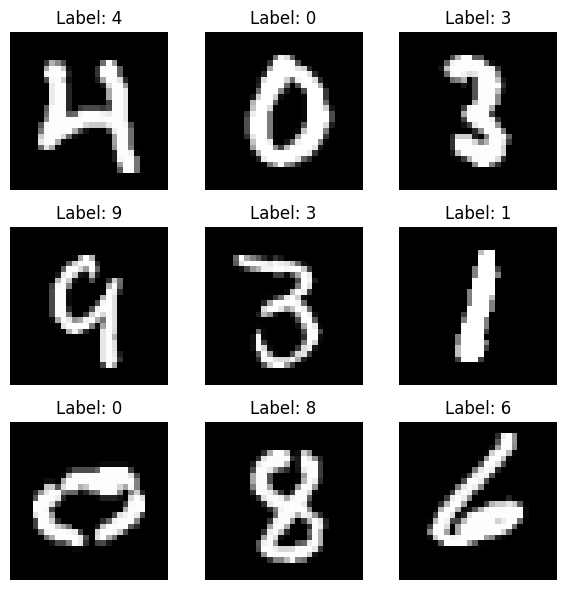

In [5]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 2-1: Implement Layers for a CNN

To build a Convolutional Neural Network (CNN) and facilitate optimization, you will implement the following layers and modules:

* **`Conv2D` layer** (forward and backward pass)
* **`BatchNorm2D` layer** (forward and backward pass)
* **`ReLU` activation** (forward and backward pass)
* **`AvgPool2D` layer** (forward and backward pass)
* **`Softmax` activation** (forward and backward pass)
* **`Linear (Fully Connected)` layer** (forward and backward pass)

Detailed descriptions of each module and their functions are provided below.


In [6]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, pad_size=1):
        """
        Initialize the Conv2D layer. 

        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels (filters).
        - kernel_size (int): Size of the convolutional kernel/filter (assumed square).
        - pad_size (int): Padding size of a standard convolutional layer.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pad_size = pad_size

        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) \
                        * np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        
        self.bias = np.zeros(out_channels)


    def forward(self, x):
        """
        Forward pass of the convolution.

        Parameters:
        - x (numpy array): Input data of shape (batch_size, in_channels, height, width).

        Returns:
        - output (numpy array): Output data after convolution.
                                Shape: (batch_size, out_channels, height, width)
                                (assuming padding to maintain spatial dimensions)
        """
        self.x = x
        batch_size, in_channels, height, width = x.shape
        
        self.x_padded = np.pad(x, 
                               ((0, 0), (0, 0), (self.pad_size, self.pad_size), (self.pad_size, self.pad_size)), 
                               mode='constant')
        # Vectorized patch extraction using sliding_window_view
        # 추출된 patches의 shape: (batch_size, in_channels, height, width, kernel_size, kernel_size)
        patches = np.lib.stride_tricks.sliding_window_view(self.x_padded, (self.kernel_size, self.kernel_size), axis=(2,3))
        
        output = np.einsum('b c i j p q, o c p q -> b o i j', patches, self.weights) + self.bias.reshape(1, -1, 1, 1)
        return output


    def backward(self, d_output):
        """
        Backward pass of convolution to compute gradients.

        Parameters:
        - d_output (numpy array): Gradient of loss w.r.t. layer's output.
                                  Shape: (batch_size, out_channels, height, width)

        Returns:
        - d_input (numpy array): Gradient of loss w.r.t. layer's input.
                                 Shape: same as original input.
        
        - d_weights (numpy array): Gradient of loss w.r.t. weights.
                                   Shape: same as weights.
        
        - d_bias (numpy array): Gradient of loss w.r.t. biases.
                                Shape: same as bias.
        """
        batch_size, out_channels, out_height, out_width = d_output.shape
        
        # Vectorized gradient computation for weights using sliding_window_view on self.x_padded
        patches = np.lib.stride_tricks.sliding_window_view(self.x_padded, (self.kernel_size, self.kernel_size), axis=(2,3))
        # patches의 shape: (batch_size, in_channels, out_height, out_width, kernel_size, kernel_size)
        d_weights = np.einsum('b o i j, b c i j p q -> o c p q', d_output, patches)
        d_bias = np.sum(d_output, axis=(0,2,3))
        
        # Compute gradient for input (d_x_padded) using vectorized computation for most parts.
        grad_patches = np.einsum('b o i j, o c p q -> b c i j p q', d_output, self.weights)
        d_x_padded = np.zeros_like(self.x_padded)
        # d_x_padded는 각 커널 window에 대해 중첩되는 영역에 grad_patches를 더해 주어야 함.
        # 여기서는 kernel_size x kernel_size에 대해 2중 for문만 사용하여 for문 횟수를 줄임.
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                d_x_padded[:, :, i:i+out_height, j:j+out_width] += grad_patches[:, :, :, :, i, j]
        
        if self.pad_size > 0:
            d_input = d_x_padded[:, :, self.pad_size:-self.pad_size, self.pad_size:-self.pad_size]
        else:
            d_input = d_x_padded
        
        return d_input, d_weights, d_bias

In [7]:
class BatchNorm2D:
    def __init__(self, num_features, epsilon=1e-5, momentum=0.1):
        """
        Initialize the BatchNorm2D layer.

        Parameters:
        - num_features (int): The number of features (channels) in the input.
        - epsilon (float): A small value added to the denominator for numerical stability.
        - momentum (float): The momentum for the moving averages.

        Tips:
        - The operation of Batch Normalization (BatchNorm) layers differs between training and inference modes.
        - Refer to the original paper for more details. 
            https://arxiv.org/abs/1502.03167
            https://medium.com/data-science/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739
        """
        self.num_features = num_features
        self.epsilon = epsilon
        self.momentum = momentum
        
        self.gamma = np.ones(num_features)
        self.beta = np.zeros(num_features)
        
        self.running_mean = np.zeros(num_features)
        self.running_var = np.ones(num_features)

    def forward(self, x, is_training=True):
        """
        Forward pass of the BatchNorm2D layer.

        Parameters:
        - x (numpy array): The input data.
        - is_training (bool): A boolean indicating whether the layer is in 
                              training mode (`True`) or inference mode (`False`).

        Returns:
        - normalized_x (numpy array): The normalized input.
        """
        if is_training:
            mean = np.mean(x, axis=(0, 2, 3))
            var = np.var(x, axis=(0, 2, 3))
            std = np.sqrt(var + self.epsilon)
            
            x_hat = (x - mean.reshape(1, self.num_features, 1, 1)) / std.reshape(1, self.num_features, 1, 1)
            
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
            
            self.x = x
            self.x_hat = x_hat
            self.mean = mean
            self.var = var
            self.std = std
        else:
            std = np.sqrt(self.running_var + self.epsilon)
            x_hat = (x - self.running_mean.reshape(1, self.num_features, 1, 1)) / std.reshape(1, self.num_features, 1, 1)
        
        out = self.gamma.reshape(1, self.num_features, 1, 1) * x_hat + self.beta.reshape(1, self.num_features, 1, 1)
        return out

    def backward(self, d_output):
        """
        Backward pass of the BatchNorm2D layer.

        Parameters:
        - d_output (numpy array): The gradient of the loss with respect to the output.

        Returns:
        - d_input (numpy array): The gradient of the loss with respect to the input.
        - d_gamma (numpy array): The gradient of the loss with respect to gamma.
        - d_beta (numpy array): The gradient of the loss with respect to beta.
        """
        N, C, H, W = d_output.shape
        N_prime = N * H * W
        
        d_beta = np.sum(d_output, axis=(0, 2, 3))
        d_gamma = np.sum(d_output * self.x_hat, axis=(0, 2, 3))
        
        d_x_hat = d_output * self.gamma.reshape(1, C, 1, 1)
        
        d_x_hat_sum = np.sum(d_x_hat, axis=(0, 2, 3), keepdims=True)
        d_x_hat_xhat_sum = np.sum(d_x_hat * self.x_hat, axis=(0, 2, 3), keepdims=True)
        
        d_input = (1.0 / N_prime) * (1.0 / self.std.reshape(1, C, 1, 1)) * (N_prime * d_x_hat - d_x_hat_sum - self.x_hat * d_x_hat_xhat_sum)
        
        return d_input, d_gamma, d_beta

In [8]:
class ReLU:
    def __init__(self):
        """
        Initialize the ReLU layer.
        """
        self.input = None

    def forward(self, x):
        """
        Forward pass of the ReLU layer.

        Parameters:
        - x (numpy array): The input data.

        Returns:
        - output (numpy array): The ReLU output.
        """
        self.input = x
        return np.maximum(0, x)

    def backward(self, d_output):
        """
        Backward pass of the ReLU layer.

        Parameters:
        - d_output (numpy array): The gradient of the loss with respect to the output.

        Returns:
        - d_input (numpy array): The gradient of the loss with respect to the input.
        """
        
        d_input = d_output * (self.input > 0)
        return d_input

In [9]:
class AvgPool2D:
    def __init__(self, kernel_size):
        """
        Initialize the AvgPool2D layer.

        Parameters:
        - kernel_size: Size of the pooling window (assumed square).
                       Stride is set equal to kernel_size by default.
        """
        self.kernel_size = kernel_size
        self.stride = kernel_size

    def forward(self, x):
        """
        Forward pass of the AvgPool2D.

        Parameters:
        - x: Input data of shape (batch_size, channels, height, width).

        Returns:
        - output: Pooled output.
        """
        self.x = x  
        batch_size, channels, height, width = x.shape
        out_height = height // self.kernel_size
        out_width = width // self.kernel_size
        
        # Vectorized average pooling via reshape and mean
        x_reshaped = x.reshape(batch_size, channels, out_height, self.kernel_size, out_width, self.kernel_size)
        output = x_reshaped.mean(axis=(3,5))
        return output

    def backward(self, d_output):
        """
        Backward pass of the AvgPool2D.

        Parameters:
        - d_output: Gradient w.r.t. the pooled output.

        Returns:
        - d_input: Gradient w.r.t. the input data.
        """
        batch_size, channels, height, width = self.x.shape
        out_height = height // self.kernel_size
        out_width = width // self.kernel_size
        
        # Distribute gradients equally to each element in the pooling window
        grad = d_output / (self.kernel_size * self.kernel_size)
        # Vectorized gradient distribution using repeat
        d_input = np.repeat(np.repeat(grad, self.kernel_size, axis=2), self.kernel_size, axis=3)
        return d_input

In [10]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Initialize the  fully connected (linear) layer.

        Parameters:
        - in_features (int): Number of input features.
        - out_features (int): Number of output features (neurons).
        """
        self.in_features = in_features
        self.out_features = out_features

        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.bias = np.zeros(out_features)

    def forward(self, x):
        """
        Forward pass of the linear layer.

        Parameters:
        - x (numpy array): Input data of shape (batch_size, in_features).

        Returns:
        - output (numpy array): Output data after linear transformation.
                                Shape: (batch_size, out_features)
        """
        self.x = x  
        output = x.dot(self.weights) + self.bias
        return output

    def backward(self, d_output):
        """
        Backward pass of the linear layer.

        Parameters:
        - d_output (numpy array): Gradient of loss w.r.t. layer's output.
                                  Shape: (batch_size, out_features)

        Returns:
        - d_input (numpy array): Gradient of loss w.r.t. layer's input.
                                 Shape: (batch_size, in_features)
        
        - d_weights (numpy array): Gradient of loss w.r.t. weights.
                                   Shape: same as weights.
        
        - d_bias (numpy array): Gradient of loss w.r.t. biases.
                                Shape: same as bias.
        """
        d_input = d_output.dot(self.weights.T)
        d_weights = self.x.T.dot(d_output)
        d_bias = np.sum(d_output, axis=0)
        return d_input, d_weights, d_bias

In [11]:
class Softmax:
    def __init__(self):
        """
        Initialize the Softmax layer.
        """
        self.output = None

    def forward(self, x):
        """
        Forward pass of the Softmax layer.

        Parameters:
        - x (numpy array): The input data.

        Returns:
        - output (numpy array): The softmax output.
        """
        x_stable = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_stable)
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, d_output):
        """
        Backward pass of the Softmax layer.

        Parameters:
        - d_output (numpy array): The gradient of the loss with respect to the output.

        Returns:
        - d_input (numpy array): Gradient of loss w.r.t layer's input.
                                 Shape: same as input
        """
        s = self.output
        d_input = s * (d_output - np.sum(d_output * s, axis=1, keepdims=True))
        return d_input

In [12]:
class CNN:
    def __init__(self):
        """
        Initialize the CNN model with the following layers:
            Conv2D(1, 32, 3, 1) - BatchNorm2D - ReLU - AvgPool2D(2) - Conv2D(32, 64, 3, 1) - BatchNorm2D - ReLU - AvgPool2D(2) - Linear - Softmax
        """
        self.conv1 = Conv2D(1, 32, 3, pad_size=1)
        self.bn1 = BatchNorm2D(32)
        self.relu1 = ReLU()
        self.pool1 = AvgPool2D(2)
        
        self.conv2 = Conv2D(32, 64, 3, pad_size=1)
        self.bn2 = BatchNorm2D(64)
        self.relu2 = ReLU()
        self.pool2 = AvgPool2D(2)
        
        self.fc = Linear(64 * 7 * 7, 10)
        self.softmax = Softmax()

    def forward(self, x, is_training):
        """
        Forward pass of the CNN.

        Parameters:
        - x (numpy array): Input data of shape (batch_size, channels, height, width).
        - is_training (bool): A boolean indicating whether the layer is in 
                              training mode (`True`) or inference mode (`False`).

        Returns:
        - output (numpy array): The output probabilities after softmax.
                                Shape: (batch_size, num_classes).
        """
        out = self.conv1.forward(x)
        out = self.bn1.forward(out, is_training)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)
        
        out = self.conv2.forward(out)
        out = self.bn2.forward(out, is_training)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)
        
        batch_size = out.shape[0]
        out_flat = out.reshape(batch_size, -1)
        out = self.fc.forward(out_flat)
        out = self.softmax.forward(out)
        return out

    def backward(self, d_output):
        """
        Backward pass of the CNN.

        Parameters:
        - d_output (numpy array): Gradient of loss w.r.t. model's output.
                                  Shape: (batch_size, num_classes).

        Returns:
        - gradients (dict): Dictionary containing gradients for all trainable parameters.
                            Used for updating weights and biases during training.
                            
                            In our implementation, each key corresponds to the attribute name in the CNN,
                            e.g., conv1_weights and conv1_bias, and the value is the corresponding gradients.
        """
        d_softmax = self.softmax.backward(d_output)
        
        d_fc, d_fc_weights, d_fc_bias = self.fc.backward(d_softmax)
        batch_size = d_fc.shape[0]
        d_fc_reshaped = d_fc.reshape(batch_size, 64, 7, 7)
        
        d_pool2 = self.pool2.backward(d_fc_reshaped)
        d_relu2 = self.relu2.backward(d_pool2)
        d_bn2, d_bn2_gamma, d_bn2_beta = self.bn2.backward(d_relu2)
        d_conv2, d_conv2_weights, d_conv2_bias = self.conv2.backward(d_bn2)
        
        d_pool1 = self.pool1.backward(d_conv2)
        d_relu1 = self.relu1.backward(d_pool1)
        d_bn1, d_bn1_gamma, d_bn1_beta = self.bn1.backward(d_relu1)
        d_conv1, d_conv1_weights, d_conv1_bias = self.conv1.backward(d_bn1)
        
        gradients = {
            'conv1_weights': d_conv1_weights,
            'conv1_bias': d_conv1_bias,
            'bn1_gamma': d_bn1_gamma,
            'bn1_beta': d_bn1_beta,
            'conv2_weights': d_conv2_weights,
            'conv2_bias': d_conv2_bias,
            'bn2_gamma': d_bn2_gamma,
            'bn2_beta': d_bn2_beta,
            'fc_weights': d_fc_weights,
            'fc_bias': d_fc_bias
        }
        return gradients

    def get_params(self):
        """
        Retrieve all trainable parameters of the model.

        Returns:
        - params (dict): Dictionary containing all trainable parameters.
                         Keys correspond to parameter names and values are numpy arrays.
                         Used for optimization during training.
        """
        params = {
            'conv1_weights': self.conv1.weights,
            'conv1_bias': self.conv1.bias,
            'bn1_gamma': self.bn1.gamma,
            'bn1_beta': self.bn1.beta,
            'conv2_weights': self.conv2.weights,
            'conv2_bias': self.conv2.bias,
            'bn2_gamma': self.bn2.gamma,
            'bn2_beta': self.bn2.beta,
            'fc_weights': self.fc.weights,
            'fc_bias': self.fc.bias
        }
        return params

### Step 2-2: Implement an SGD Optimizer

Detailed descriptions of the SGD optimizer are provided below.

In [13]:
class SGD:
    def __init__(self, learning_rate=0.005, momentum=0.9):
        """
        Initialize the SGD optimizer.

        Parameters:
        - learning_rate (float): The step size for each gradient descent update.
        - momentum (float): The momentum factor to add a fraction of the previous update to the current one.
        """
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}

    def update(self, params, gradients):
        """
        Update the model parameters based on the gradients.

        Parameters:
        - params (dict): A dictionary of model parameters.
        - gradients (dict): A dictionary of gradients corresponding to the parameters.
        """
        for key in params.keys():
            if key not in self.velocity:
                self.velocity[key] = np.zeros_like(params[key])
            self.velocity[key] = self.momentum * self.velocity[key] - self.learning_rate * gradients[key]
            params[key] += self.velocity[key]

### Step 3: Train CNN on the MNIST Dataset

Implement code to train your CNN model on the MNIST dataset using a cross-entropy loss.

Additionally, you are required to:
- Plot the **loss curve** and **accuracy curve** during training.
- Include the results in your report.

**Tips:**
- Randomizing the input sequence by shuffling training data can accelerate convergence.
- Our implementation achieves **94.5% accuracy** on the training set when trained for **1 epoch**.

In [14]:
model = CNN()
optimizer = SGD(learning_rate=lr, momentum=0.9)

In [15]:
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

def cross_entropy_loss(pred, target):
    epsilon = 1e-12
    pred = np.clip(pred, epsilon, 1. - epsilon)
    loss = - np.sum(target * np.log(pred)) / pred.shape[0]
    return loss

### Step 4: Inference on the MNIST Test Split

Compute the classification accuracy of your model on the test dataset.

In [16]:
############################################################
# Define CNN variant with 1 convolutional layer (CNN_1Conv)
############################################################
class CNN_1Conv:
    def __init__(self):
        """
        Initialize the CNN model with a single convolutional layer.
        Architecture:
         Conv2D(1, 32, 3, pad_size=1) -> BatchNorm2D -> ReLU -> AvgPool2D(2) -> Flatten -> Linear -> Softmax
        Note: For an input image of size 28x28, after pooling, spatial dimensions become 14x14.
        """
        self.conv1 = Conv2D(1, 32, 3, pad_size=1)
        self.bn1 = BatchNorm2D(32)
        self.relu1 = ReLU()
        self.pool1 = AvgPool2D(2)
        self.fc = Linear(32 * 14 * 14, 10)
        self.softmax = Softmax()

    def forward(self, x, is_training):
        out = self.conv1.forward(x)
        out = self.bn1.forward(out, is_training)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)
        batch_size = out.shape[0]
        out_flat = out.reshape(batch_size, -1)
        out = self.fc.forward(out_flat)
        out = self.softmax.forward(out)
        return out

    def backward(self, d_output):
        d_softmax = self.softmax.backward(d_output)
        d_fc, d_fc_weights, d_fc_bias = self.fc.backward(d_softmax)
        batch_size = d_fc.shape[0]
        # Reshape gradient to match pooling output (shape: (batch_size, 32, 14, 14))
        d_fc_reshaped = d_fc.reshape(batch_size, 32, 14, 14)
        d_pool1 = self.pool1.backward(d_fc_reshaped)
        d_relu1 = self.relu1.backward(d_pool1)
        d_bn1, d_bn1_gamma, d_bn1_beta = self.bn1.backward(d_relu1)
        d_conv1, d_conv1_weights, d_conv1_bias = self.conv1.backward(d_bn1)
        gradients = {
            'conv1_weights': d_conv1_weights,
            'conv1_bias': d_conv1_bias,
            'bn1_gamma': d_bn1_gamma,
            'bn1_beta': d_bn1_beta,
            'fc_weights': d_fc_weights,
            'fc_bias': d_fc_bias
        }
        return gradients

    def get_params(self):
        params = {
            'conv1_weights': self.conv1.weights,
            'conv1_bias': self.conv1.bias,
            'bn1_gamma': self.bn1.gamma,
            'bn1_beta': self.bn1.beta,
            'fc_weights': self.fc.weights,
            'fc_bias': self.fc.bias
        }
        return params

In [17]:
##############################################
# Training and Evaluation Functions
##############################################
def train_model(model, optimizer, train_loader, num_epochs=1):
    """
    Train the given model for a specified number of epochs.

    Returns:
      - Average loss, overall accuracy, total training time,
      - Batch-level loss history and accuracy history (for plotting).
    """
    batch_loss_history = []
    batch_accuracy_history = []
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    start_time = time.time()
    total_batches = len(train_loader)
    
    for batch_index, (images, labels) in enumerate(train_loader, 1):
        iter_start = time.time()
        images_np = images.numpy()
        labels_np = labels.numpy()
        onehot = one_hot(labels_np)
        
        # Forward pass in training mode
        outputs = model.forward(images_np, is_training=True)
        loss = cross_entropy_loss(outputs, onehot)
        batch_loss_history.append(loss)
        
        # Calculate batch accuracy
        predictions = np.argmax(outputs, axis=1)
        acc = np.sum(predictions == labels_np) / labels_np.shape[0]
        batch_accuracy_history.append(acc)
        
        total_loss += loss
        total_correct += np.sum(predictions == labels_np)
        total_samples += labels_np.shape[0]
        
        # Compute gradient and update parameters
        d_loss = (outputs - onehot) / images_np.shape[0]
        gradients = model.backward(d_loss)
        optimizer.update(model.get_params(), gradients)
        
        # Calculate iteration time and ETA
        iter_time = time.time() - iter_start
        remaining_batches = total_batches - batch_index
        eta = remaining_batches * iter_time
        
        # Print batch progress information
        print(f"[batch {batch_index}/{total_batches}] accuracy: {acc:.4f}, loss: {loss:.4f}, ETA: {eta:.2f} s")
    
    end_time = time.time()
    training_time = end_time - start_time
    avg_loss = total_loss / total_batches
    overall_accuracy = total_correct / total_samples
    return avg_loss, overall_accuracy, training_time, batch_loss_history, batch_accuracy_history

In [18]:
def evaluate_model(model, test_loader):
    """
    Evaluate the given model on the test dataset.
    
    Returns:
      - Average test loss and overall accuracy.
    """
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for images, labels in test_loader:
        images_np = images.numpy()
        labels_np = labels.numpy()
        onehot = one_hot(labels_np)
        
        outputs = model.forward(images_np, is_training=False)
        loss = cross_entropy_loss(outputs, onehot)
        total_loss += loss
        
        predictions = np.argmax(outputs, axis=1)
        total_correct += np.sum(predictions == labels_np)
        total_samples += labels_np.shape[0]
    
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [19]:
##############################################
# Performance and Training Time Comparison Code
##############################################
# For fair comparison, we use the same optimizer settings
# and training parameters (e.g., learning rate, batch size).

# Instantiate and train the model with 2 convolutional layers (our main model)
model_2 = CNN()  # Using the previously defined CNN (with two convolutional layers)
optimizer_2 = SGD(learning_rate=lr, momentum=0.9)
avg_loss_2, train_acc_2, train_time_2, batch_loss_history_2, batch_accuracy_history_2 = train_model(
    model_2, optimizer_2, train_loader, num_epochs=1)
test_loss_2, test_acc_2 = evaluate_model(model_2, test_loader)

print("\nModel with 2 Convolutional Layers:")
print(f"Final Training Time: {train_time_2:.2f} s, Training Loss: {avg_loss_2:.4f}, Training Accuracy: {train_acc_2:.2%}")
print(f"Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_acc_2:.2%}")

[batch 1/600] accuracy: 0.1400, loss: 2.5244, ETA: 4467.65 s
[batch 2/600] accuracy: 0.0800, loss: 2.6211, ETA: 4420.59 s
[batch 3/600] accuracy: 0.1100, loss: 2.6707, ETA: 4425.86 s
[batch 4/600] accuracy: 0.1500, loss: 2.4264, ETA: 4345.17 s
[batch 5/600] accuracy: 0.1600, loss: 2.4022, ETA: 4376.18 s
[batch 6/600] accuracy: 0.1500, loss: 2.4165, ETA: 4304.30 s
[batch 7/600] accuracy: 0.2600, loss: 2.3282, ETA: 4328.75 s
[batch 8/600] accuracy: 0.2600, loss: 2.2480, ETA: 4331.90 s
[batch 9/600] accuracy: 0.2200, loss: 2.2437, ETA: 4333.33 s
[batch 10/600] accuracy: 0.2900, loss: 2.1701, ETA: 4322.27 s
[batch 11/600] accuracy: 0.3000, loss: 2.2172, ETA: 4303.45 s
[batch 12/600] accuracy: 0.2800, loss: 2.1797, ETA: 4301.30 s
[batch 13/600] accuracy: 0.3400, loss: 2.0251, ETA: 4292.46 s
[batch 14/600] accuracy: 0.2800, loss: 2.1576, ETA: 4277.68 s
[batch 15/600] accuracy: 0.4000, loss: 1.9389, ETA: 4261.54 s
[batch 16/600] accuracy: 0.5100, loss: 1.8493, ETA: 4265.18 s
[batch 17/600] ac

In [20]:
# Instantiate and train the model with 1 convolutional layer (baseline)
model_1 = CNN_1Conv()
optimizer_1 = SGD(learning_rate=lr, momentum=0.9)
avg_loss_1, train_acc_1, train_time_1, batch_loss_history_1, batch_accuracy_history_1 = train_model(
    model_1, optimizer_1, train_loader, num_epochs=1)
test_loss_1, test_acc_1 = evaluate_model(model_1, test_loader)

# Print out final training and test performance for comparison
print("\nModel with 1 Convolutional Layer:")
print(f"Final Training Time: {train_time_1:.2f} s, Training Loss: {avg_loss_1:.4f}, Training Accuracy: {train_acc_1:.2%}")
print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_acc_1:.2%}")

[batch 1/600] accuracy: 0.0500, loss: 2.7903, ETA: 342.84 s
[batch 2/600] accuracy: 0.0900, loss: 2.6127, ETA: 315.66 s
[batch 3/600] accuracy: 0.0900, loss: 2.6422, ETA: 337.14 s
[batch 4/600] accuracy: 0.0800, loss: 2.5920, ETA: 360.04 s
[batch 5/600] accuracy: 0.1600, loss: 2.4230, ETA: 310.46 s
[batch 6/600] accuracy: 0.1000, loss: 2.4403, ETA: 323.97 s
[batch 7/600] accuracy: 0.1500, loss: 2.3432, ETA: 313.35 s
[batch 8/600] accuracy: 0.2000, loss: 2.2993, ETA: 317.07 s
[batch 9/600] accuracy: 0.2700, loss: 2.1944, ETA: 317.53 s
[batch 10/600] accuracy: 0.2200, loss: 2.3094, ETA: 348.70 s
[batch 11/600] accuracy: 0.2700, loss: 2.1483, ETA: 319.38 s
[batch 12/600] accuracy: 0.2500, loss: 2.0801, ETA: 337.53 s
[batch 13/600] accuracy: 0.3800, loss: 1.9648, ETA: 348.52 s
[batch 14/600] accuracy: 0.4000, loss: 1.8411, ETA: 308.27 s
[batch 15/600] accuracy: 0.4500, loss: 1.8317, ETA: 357.80 s
[batch 16/600] accuracy: 0.4900, loss: 1.7591, ETA: 329.41 s
[batch 17/600] accuracy: 0.5200, 

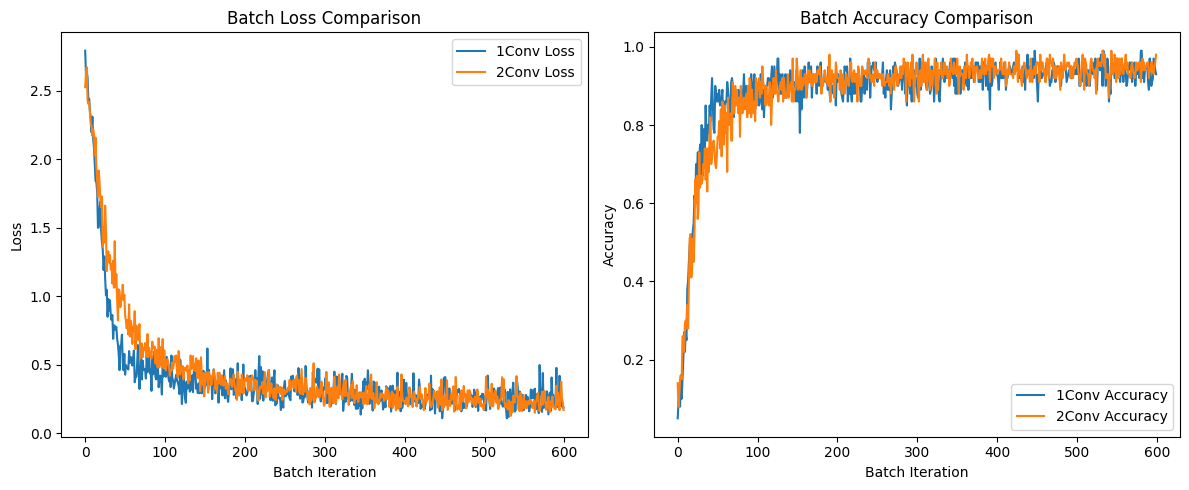

In [21]:
# Plot batch-level performance curves for a visual comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_loss_history_1, label='1Conv Loss')
plt.plot(batch_loss_history_2, label='2Conv Loss')
plt.title('Batch Loss Comparison')
plt.xlabel('Batch Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_accuracy_history_1, label='1Conv Accuracy')
plt.plot(batch_accuracy_history_2, label='2Conv Accuracy')
plt.title('Batch Accuracy Comparison')
plt.xlabel('Batch Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
##############################################
# Save the model for future validation
##############################################
# Save model_2 (our main model) parameters along with optimizer state
model_save_dict = {
    'model_parameters': model_2.get_params(),
    'optimizer_velocity': optimizer_2.velocity
}
with open('model_2_parameters.pkl', 'wb') as f:
    pickle.dump(model_save_dict, f)
print("Model saved to 'model_2_parameters.pkl'")

Model saved to 'model_2_parameters.pkl'


In [23]:
def extract_features_model_1(model, loader):
    """
    Extract feature representations from CNN_1Conv.
    The features are taken from the output of the pooling layer (after ReLU).
    """
    features_list = []
    labels_list = []
    for images, labels in tqdm(loader, desc='Extracting features for Model 1'):
        images_np = images.numpy()
        labels_np = labels.numpy()
        # Forward pass for feature extraction (Model 1)
        out = model.conv1.forward(images_np)
        out = model.bn1.forward(out, is_training=False)
        out = model.relu1.forward(out)
        out = model.pool1.forward(out)
        batch_size = out.shape[0]
        # Flatten the output
        features = out.reshape(batch_size, -1)
        features_list.append(features)
        labels_list.append(labels_np)
    features_all = np.concatenate(features_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)
    return features_all, labels_all

In [24]:
def extract_features_model_2(model, loader):
    """
    Extract feature representations from CNN (with 2 convolutional layers).
    The features are taken from the output of the second pooling layer (after ReLU).
    """
    features_list = []
    labels_list = []
    for images, labels in tqdm(loader, desc='Extracting features for Model 2'):
        images_np = images.numpy()
        labels_np = labels.numpy()
        # Forward pass for feature extraction (Model 2)
        out = model.conv1.forward(images_np)
        out = model.bn1.forward(out, is_training=False)
        out = model.relu1.forward(out)
        out = model.pool1.forward(out)
        out = model.conv2.forward(out)
        out = model.bn2.forward(out, is_training=False)
        out = model.relu2.forward(out)
        out = model.pool2.forward(out)
        batch_size = out.shape[0]
        # Flatten the output
        features = out.reshape(batch_size, -1)
        features_list.append(features)
        labels_list.append(labels_np)
    features_all = np.concatenate(features_list, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)
    return features_all, labels_all

Extracting features for Model 2: 100%|██████████| 100/100 [05:07<00:00,  3.08s/it]
/opt/anaconda3/envs/comvi/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/comvi/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/comvi/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/comvi/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


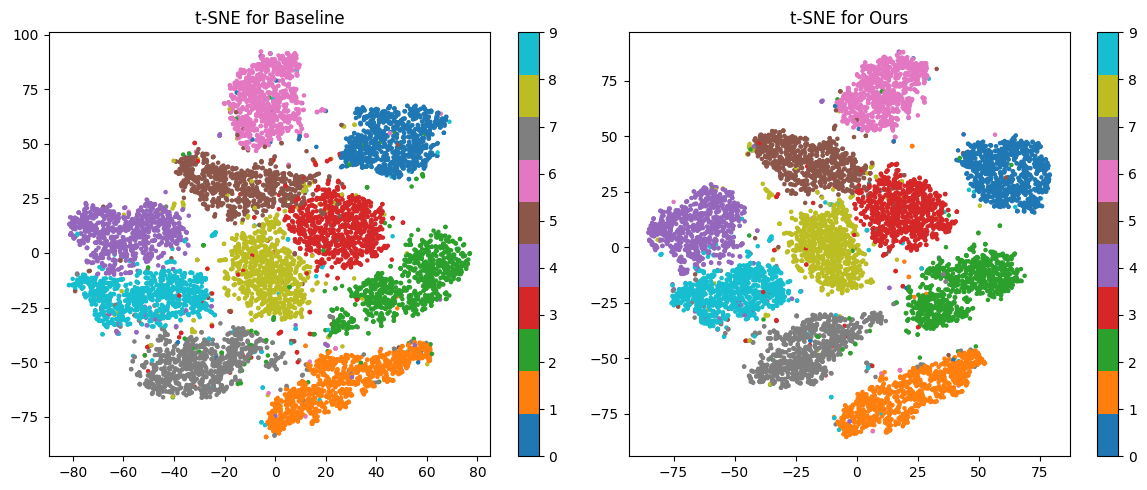

In [25]:
# Extract features using the test dataset for both models
features_1, labels_1 = extract_features_model_1(model_1, test_loader)
features_2, labels_2 = extract_features_model_2(model_2, test_loader)

# Apply t-SNE on the extracted features
tsne_1 = TSNE(n_components=2, random_state=42)
tsne_results_1 = tsne_1.fit_transform(features_1)

tsne_2 = TSNE(n_components=2, random_state=42)
tsne_results_2 = tsne_2.fit_transform(features_2)

# Plot t-SNE results for both models in a side-by-side figure
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(tsne_results_1[:, 0], tsne_results_1[:, 1], c=labels_1, cmap='tab10', s=5)
plt.colorbar(scatter1, ticks=range(10))
plt.title('t-SNE for Baseline')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(tsne_results_2[:, 0], tsne_results_2[:, 1], c=labels_2, cmap='tab10', s=5)
plt.colorbar(scatter2, ticks=range(10))
plt.title('t-SNE for Ours')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()